# Regressão Árvore de Decisão

### 1. Configuração Inicial

In [14]:
# Importações necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Importações do scikit-learn
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer

In [15]:
# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
%matplotlib inline

### 2. Carregamento dos Dados

In [16]:
# Carregamento dos Dados
print("Carregando os dados...")
data_dir = Path('../data/raw')
train_path = data_dir / 'train.csv'
test_path = data_dir / 'test.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Dados de treino carregados: {train_df.shape}")
    print(f"Dados de teste carregados: {test_df.shape}")
except Exception as e:
    print(f"Erro ao carregar os dados: {e}")
    raise

Carregando os dados...
Dados de treino carregados: (1460, 81)
Dados de teste carregados: (1459, 80)


### 3. Análise Exploratória de Dados (EDA)

Visualizando as primeiras linhas do conjunto de treino:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Estatísticas descritivas das variáveis numéricas:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



Valores ausentes por coluna (treino):


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

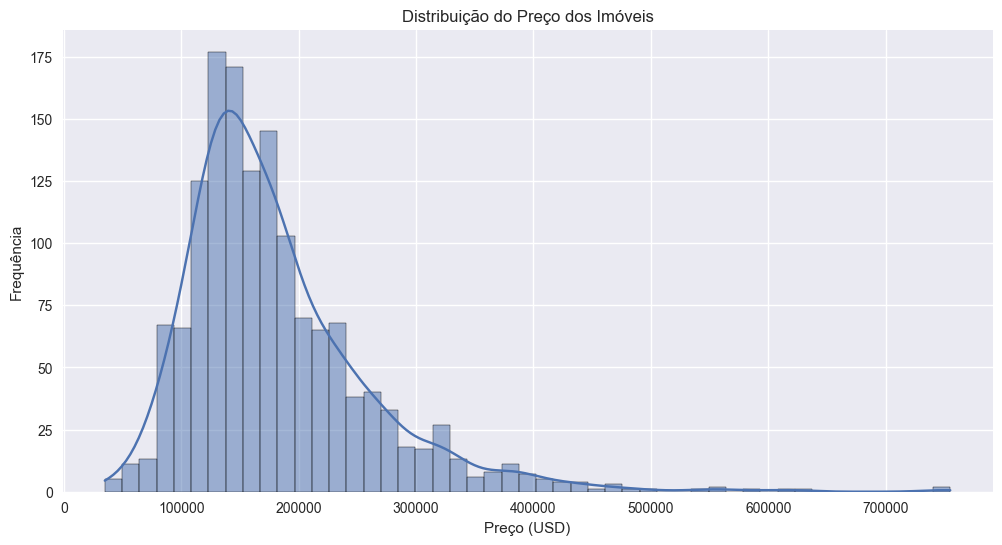

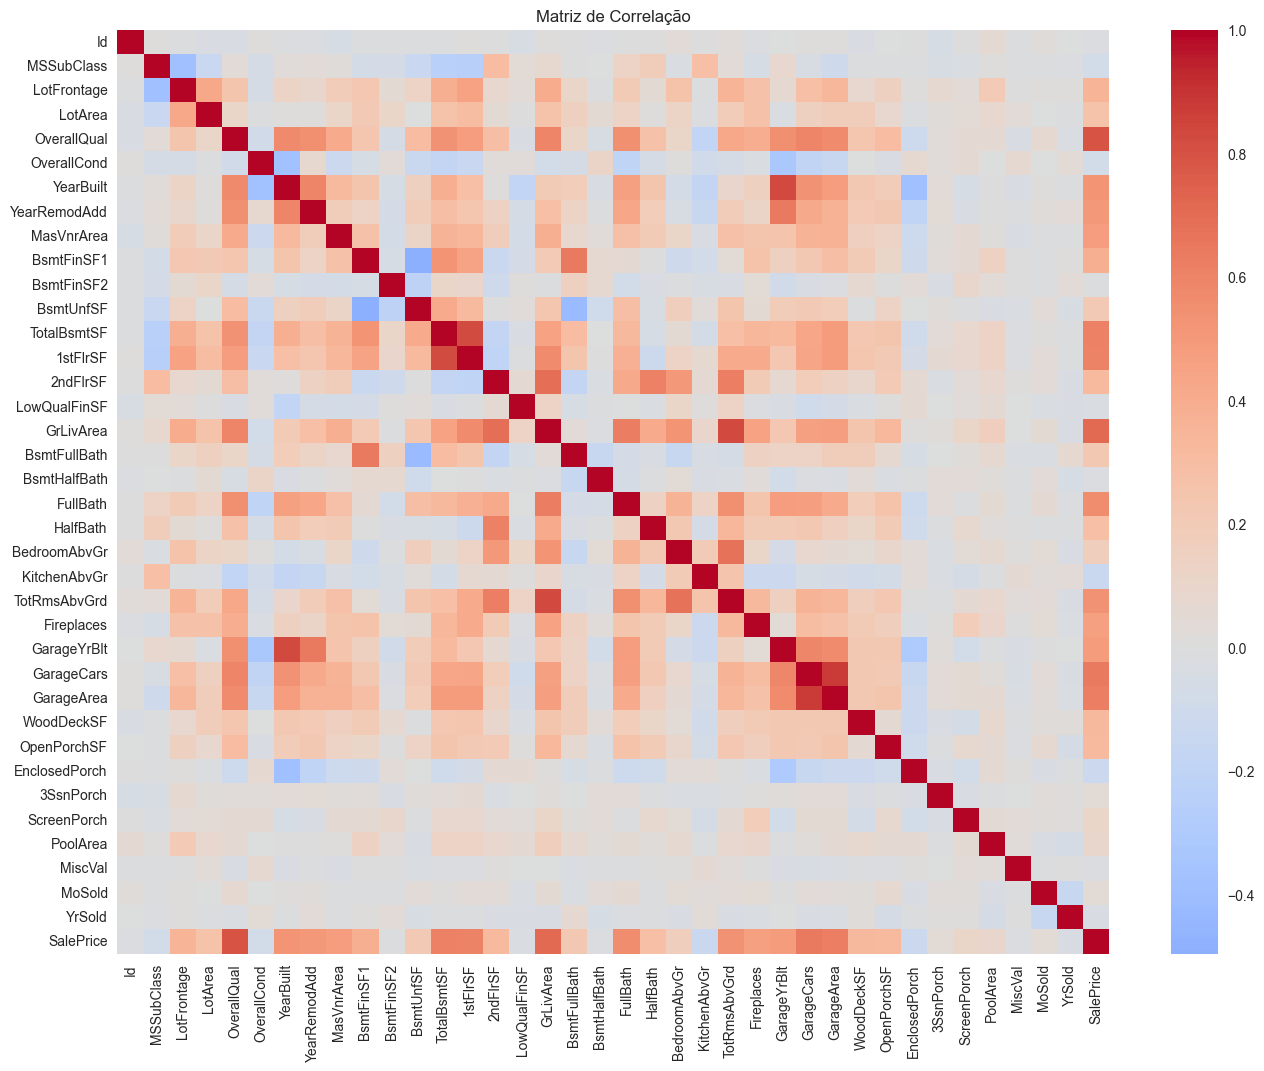

In [17]:
 # Visualização das primeiras linhas
print("Visualizando as primeiras linhas do conjunto de treino:")
display(train_df.head())

# Estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
display(train_df.describe())

# Verificando valores ausentes
print("\nValores ausentes por coluna (treino):")
missing_train = train_df.isnull().sum().sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
display(missing_train)

# Distribuição do preço dos imóveis
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribuição do Preço dos Imóveis')
plt.xlabel('Preço (USD)')
plt.ylabel('Frequência')
plt.show()

# Correlação entre variáveis numéricas
plt.figure(figsize=(16, 12))
corr_matrix = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

### 4. Pré-processamento dos Dados

In [18]:
# Separando features e target
X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']
X_test_sub = test_df.drop('Id', axis=1)

# Identificando colunas numéricas e categóricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Definindo transformações
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinando transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicando transformações
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_sub)

# Dividindo em conjuntos de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print(f"Shape dos dados de treino: {X_train.shape}")
print(f"Shape dos dados de validação: {X_val.shape}")

Shape dos dados de treino: (1168, 287)
Shape dos dados de validação: (292, 287)


### 5. Treinamento do Modelo de Árvore de Decisão

In [19]:
# Criando o modelo base
dt_model = DecisionTreeRegressor(random_state=42)

# Treinando o modelo
dt_model.fit(X_train, y_train)

# Fazendo previsões
y_train_pred = dt_model.predict(X_train)
y_val_pred = dt_model.predict(X_val)

# Avaliando o modelo
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\nMétricas para {dataset_name}:")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R²: {r2:.4f}")
    print(f"  - MAE: {mae:.2f}")

evaluate_model(y_train, y_train_pred, "Treino")
evaluate_model(y_val, y_val_pred, "Validação")


Métricas para Treino:
  - RMSE: 0.00
  - R²: 1.0000
  - MAE: 0.00

Métricas para Validação:
  - RMSE: 40566.31
  - R²: 0.7855
  - MAE: 26586.44


### 6. Otimização de Hiperparâmetros

In [20]:
# Definindo a grade de parâmetros para busca
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Criando o modelo
dt = DecisionTreeRegressor(random_state=42)

# Busca em grade com validação cruzada
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Executando a busca
print("Iniciando busca em grade...")
grid_search.fit(X_train, y_train)

# Melhores parâmetros
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor modelo
best_dt = grid_search.best_estimator_

# Avaliando o modelo otimizado
y_train_pred_opt = best_dt.predict(X_train)
y_val_pred_opt = best_dt.predict(X_val)

evaluate_model(y_train, y_train_pred_opt, "Treino (Otimizado)")
evaluate_model(y_val, y_val_pred_opt, "Validação (Otimizado)")

Iniciando busca em grade...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

Melhores parâmetros encontrados:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 20}

Métricas para Treino (Otimizado):
  - RMSE: 25150.54
  - R²: 0.8939
  - MAE: 15054.50

Métricas para Validação (Otimizado):
  - RMSE: 40688.53
  - R²: 0.7842
  - MAE: 25542.25


d:\ProjetosGit\kaggle-regression-lab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
480 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
296 fits failed with the following error:
Traceback (most recent call last):
  File "d:\ProjetosGit\kaggle-regression-lab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\ProjetosGit\kaggle-regression-lab\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "d:\ProjetosGit\kaggle-regression-lab\

### 7. Análise de Importância das Features

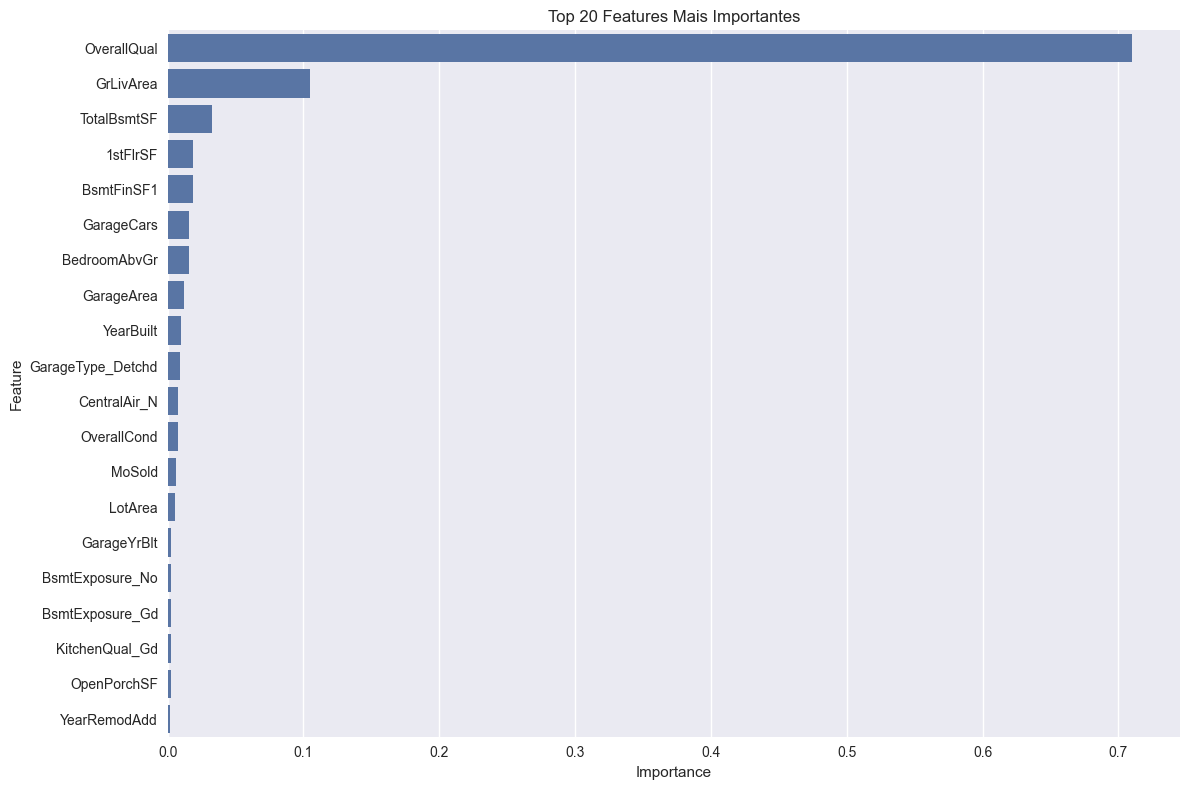

In [21]:
# Obtendo os nomes das features após o pré-processamento
numeric_features = list(numeric_cols)
categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(categorical_cols).tolist()
feature_names = numeric_features + categorical_features

# Verificando a importância das features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

# Plotando a importância das features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 20 Features Mais Importantes')
plt.tight_layout()
plt.show()

###  8. Treinamento Final e Submissão

In [22]:
# Treinando o modelo final com todos os dados de treino
print("Treinando o modelo final com todos os dados de treino...")
final_model = DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
final_model.fit(X_processed, y)

# Fazendo previsões no conjunto de teste
print("Fazendo previsões no conjunto de teste...")
test_predictions = final_model.predict(X_test_processed)

# Criando o arquivo de submissão
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_predictions
})

# Salvando o arquivo de submissão
submission_path = '../outputs/submission_decision_tree.csv'
submission.to_csv(submission_path, index=False)
print(f"\nArquivo de submissão salvo em: {submission_path}")

# Visualizando as primeiras linhas da submissão
print("\nVisualização das primeiras previsões:")
display(submission.head())

Treinando o modelo final com todos os dados de treino...
Fazendo previsões no conjunto de teste...

Arquivo de submissão salvo em: ../outputs/submission_decision_tree.csv

Visualização das primeiras previsões:


,Id,SalePrice
0,1461,155666.666667
1,1462,152116.666667
2,1463,175806.250000
3,1464,174515.277778
4,1465,226686.444444


### 9. Análise de Overfitting e Underfitting

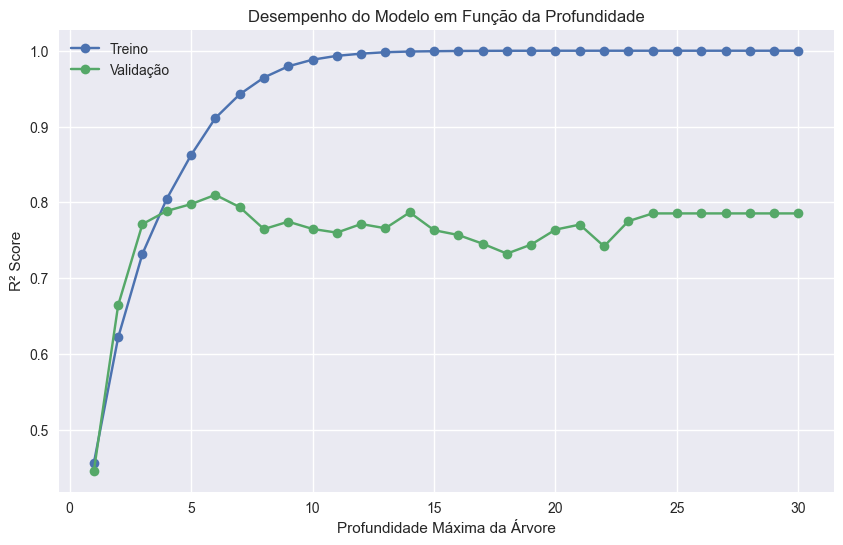

In [23]:
# Avaliando o desempenho em diferentes profundidades da árvore
max_depths = range(1, 31)
train_scores = []
val_scores = []

for depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Scores de treino e validação
    train_scores.append(dt.score(X_train, y_train))
    val_scores.append(dt.score(X_val, y_val))

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Treino', marker='o')
plt.plot(max_depths, val_scores, label='Validação', marker='o')
plt.xlabel('Profundidade Máxima da Árvore')
plt.ylabel('R² Score')
plt.title('Desempenho do Modelo em Função da Profundidade')
plt.legend()
plt.grid(True)
plt.show()

### 10. Visualização da Árvore (Parcial)

In [24]:
# Criando uma árvore com profundidade limitada para visualização
from sklearn.tree import export_text

# Limitando a profundidade para 3 níveis para melhor visualização
shallow_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
shallow_tree.fit(X_train, y_train)

# Obtendo os nomes das features
feature_names = numeric_features + categorical_features

# Exportando a árvore como texto
tree_rules = export_text(
    shallow_tree,
    feature_names=feature_names,
    max_depth=3
)
print("Regras da árvore de decisão (limitada a 3 níveis):")
print(tree_rules)

Regras da árvore de decisão (limitada a 3 níveis):
|--- OverallQual <= 1.01
|   |--- OverallQual <= 0.29
|   |   |--- GrLivArea <= -0.26
|   |   |   |--- value: [125810.16]
|   |   |--- GrLivArea >  -0.26
|   |   |   |--- value: [166817.78]
|   |--- OverallQual >  0.29
|   |   |--- GrLivArea <= 0.96
|   |   |   |--- value: [194671.29]
|   |   |--- GrLivArea >  0.96
|   |   |   |--- value: [253941.80]
|--- OverallQual >  1.01
|   |--- OverallQual <= 1.74
|   |   |--- GrLivArea <= 0.87
|   |   |   |--- value: [250999.81]
|   |   |--- GrLivArea >  0.87
|   |   |   |--- value: [317233.73]
|   |--- OverallQual >  1.74
|   |   |--- 2ndFlrSF <= 3.02
|   |   |   |--- value: [363536.09]
|   |   |--- 2ndFlrSF >  3.02
|   |   |   |--- value: [685000.00]



### 11. Salvando o Modelo

In [25]:
import joblib

# Criando diretório de modelos se não existir
os.makedirs('../outputs/models', exist_ok=True)

# Salvando o modelo
model_path = '../outputs/models/decision_tree_model.joblib'
joblib.dump(final_model, model_path)
print(f"Modelo salvo em: {model_path}")

# Salvando o pré-processador
preprocessor_path = '../outputs/models/decision_tree_preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_path)
print(f"Pré-processador salvo em: {preprocessor_path}")

Modelo salvo em: ../outputs/models/decision_tree_model.joblib
Pré-processador salvo em: ../outputs/models/decision_tree_preprocessor.joblib
